# CNN + MaxPool
Excluding long sequences complicated the tracking of genes.
Also, it had a bias of affecting canonical transcripts more.
Now, keep the long sequences but truncate them.

Fixed bug in antilog computation.

Observe extreme overfitting.

In [1]:
from datetime import datetime
print(datetime.now())

2023-03-21 15:30:16.104295


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=128 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=20 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

## Model

In [7]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    cnn2_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool1_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    cnn3_layer = Conv1D(CFILTERS//2, FILTERSIZE)
    cnn4_layer = Conv1D(CFILTERS//2, FILTERSIZE)
    pool2_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    flat_layer = Flatten()
    #dens_layer = Dense(DCELLS,activation='relu')
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(cnn2_layer)
    cnn.add(pool1_layer)
    cnn.add(cnn3_layer)
    cnn.add(cnn4_layer)
    cnn.add(pool2_layer)
    cnn.add(flat_layer)
    #cnn.add(dens_layer)
    cnn.add(drop_layer)
    cnn.add(output_layer)

    # Logits=False because sigmoid output is a probability in range [0.,1.]; see
    # https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class
    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return cnn

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-21 15:30:49.999480
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 4990, 128)         4224      
                                                                 
 conv1d_1 (Conv1D)           (None, 4983, 128)         131200    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1244, 128)        0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 1237, 64)          65600     
                                                                 
 conv1d_3 (Conv1D)           (None, 1230, 64)          32832     
                             

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-21 15:30:50.410233
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-03-21 15:31:00.309055

Training # 1 1
2023-03-21 15:31:00.310253
2023-03-21 15:31:00.310309
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Computed class weights: {0: 1.029723366686286, 1: 0.9719444444444445}
Valid 1:0 458:412 52.64%
FIT
2023-03-21 15:31:01.552719


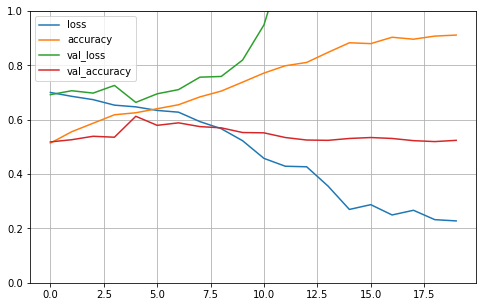


2023-03-21 15:33:25.363445

Testing # 1 1
2023-03-21 15:33:25.363548
2023-03-21 15:33:25.363588
PREDICT
2023-03-21 15:33:25.591811
Test 1:0 458:412 52.64%
Predict 1:0 340:530 39.08%
Test sizes (870, 4997) (870,)
Range of scores: 2.5420688e-10 to 1.0
Score threshold 0.5
Confusion matrix
 [[264 148]
 [266 192]]
Normalized matrix
 [[0.30344828 0.17011494]
 [0.30574713 0.22068966]]


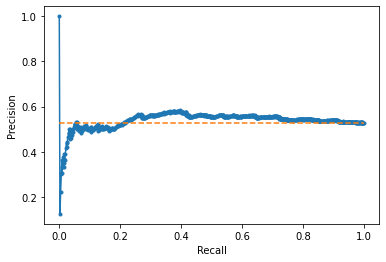

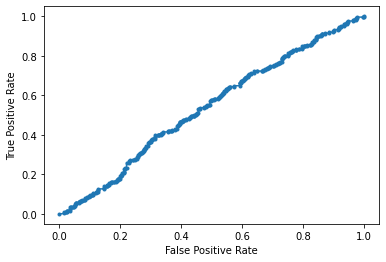

Accuracy: 52.41% Precision: 56.47% Recall: 41.92%
F1: 48.12% MCC: 0.0614
AUPRC: 53.82% AUROC: 53.82%
 accuracy [52.41379310344828]
 precision [56.470588235294116]
 recall [41.92139737991266]
 F1 [48.1203007518797]
 MCC [0.06138859396961427]
 AUPRC [53.823470917192964]
 AUROC [53.815396192818085]
2023-03-21 15:33:27.210804

Training # 1 2
2023-03-21 15:33:27.211017
2023-03-21 15:33:27.211067
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Computed class weights: {0: 1.0440383463151588, 1: 0.9595264317180616}
Valid 1:0 442:442 50.00%
FIT
2023-03-21 15:33:28.431795


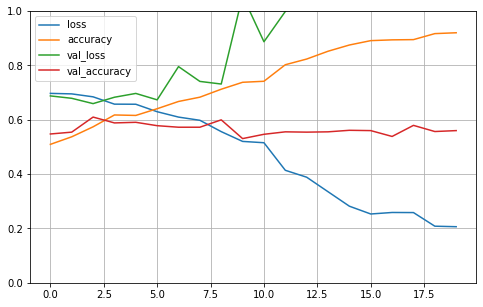


2023-03-21 15:35:51.851595

Testing # 1 2
2023-03-21 15:35:51.851694
2023-03-21 15:35:51.851732
PREDICT
2023-03-21 15:35:52.078754
Test 1:0 442:442 50.00%
Predict 1:0 509:375 57.58%
Test sizes (884, 4997) (884,)
Range of scores: 1.8117449e-10 to 1.0
Score threshold 0.5
Confusion matrix
 [[214 228]
 [161 281]]
Normalized matrix
 [[0.24208145 0.25791855]
 [0.1821267  0.3178733 ]]


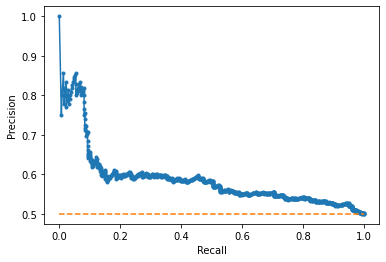

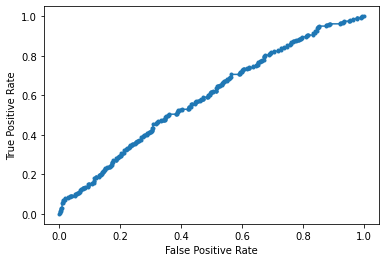

Accuracy: 56.00% Precision: 55.21% Recall: 63.57%
F1: 59.10% MCC: 0.1213
AUPRC: 58.84% AUROC: 59.31%
 accuracy [55.995475113122176]
 precision [55.20628683693517]
 recall [63.57466063348416]
 F1 [59.095688748685596]
 MCC [0.12131132452936978]
 AUPRC [58.84182578657213]
 AUROC [59.305962203886075]
2023-03-21 15:35:54.049114

Training # 1 3
2023-03-21 15:35:54.049294
2023-03-21 15:35:54.049339
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Computed class weights: {0: 1.0328638497652582, 1: 0.9691629955947136}
Valid 1:0 442:407 52.06%
FIT
2023-03-21 15:35:55.773725


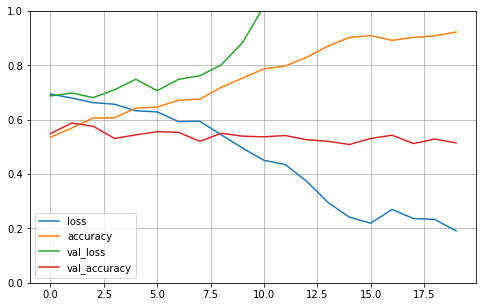


2023-03-21 15:38:05.774477

Testing # 1 3
2023-03-21 15:38:05.774616
2023-03-21 15:38:05.774659
PREDICT
2023-03-21 15:38:06.322410
Test 1:0 442:407 52.06%
Predict 1:0 296:553 34.86%
Test sizes (849, 4997) (849,)
Range of scores: 5.3494945e-11 to 1.0
Score threshold 0.5
Confusion matrix
 [[274 133]
 [279 163]]
Normalized matrix
 [[0.32273263 0.15665489]
 [0.32862191 0.19199058]]


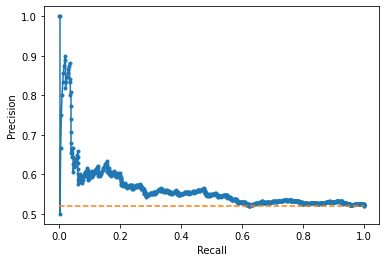

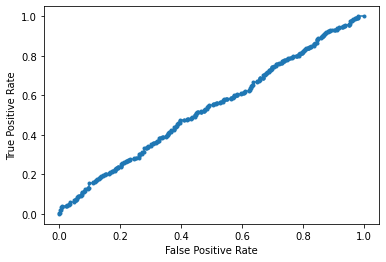

Accuracy: 51.47% Precision: 55.07% Recall: 36.88%
F1: 44.17% MCC: 0.0440
AUPRC: 56.34% AUROC: 53.49%
 accuracy [51.47232037691401]
 precision [55.067567567567565]
 recall [36.87782805429865]
 F1 [44.173441734417345]
 MCC [0.04402685955063978]
 AUPRC [56.338334503978004]
 AUROC [53.48538583832701]
2023-03-21 15:38:08.706726

Training # 1 4
2023-03-21 15:38:08.724750
2023-03-21 15:38:08.725132
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Computed class weights: {0: 1.0354166666666667, 1: 0.9669260700389105}
Valid 1:0 459:431 51.57%
FIT
2023-03-21 15:38:12.843249


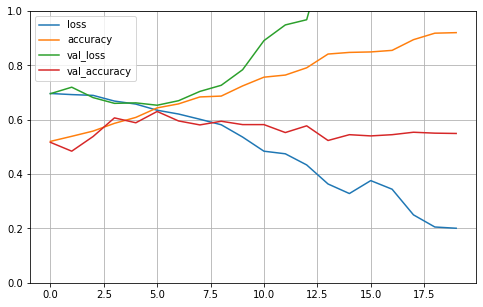


2023-03-21 15:40:36.775338

Testing # 1 4
2023-03-21 15:40:36.775638
2023-03-21 15:40:36.775681
PREDICT
2023-03-21 15:40:37.004072
Test 1:0 459:431 51.57%
Predict 1:0 560:330 62.92%
Test sizes (890, 4997) (890,)
Range of scores: 2.5511602e-07 to 1.0
Score threshold 0.5
Confusion matrix
 [[180 251]
 [150 309]]
Normalized matrix
 [[0.20224719 0.28202247]
 [0.16853933 0.34719101]]


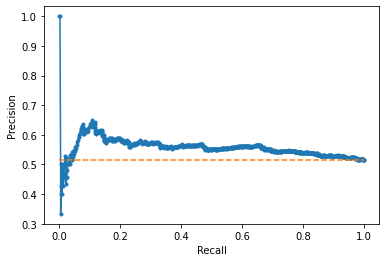

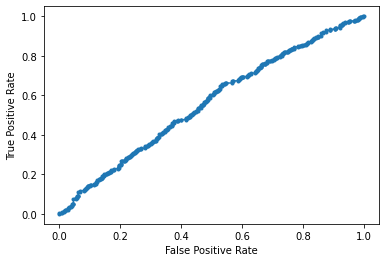

Accuracy: 54.94% Precision: 55.18% Recall: 67.32%
F1: 60.65% MCC: 0.0940
AUPRC: 55.77% AUROC: 55.91%
 accuracy [54.9438202247191]
 precision [55.17857142857143]
 recall [67.3202614379085]
 F1 [60.64769381746812]
 MCC [0.09398360851671567]
 AUPRC [55.77202304793447]
 AUROC [55.91445136961719]
2023-03-21 15:40:38.637151

Training # 1 5
2023-03-21 15:40:38.638284
2023-03-21 15:40:38.638336
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Computed class weights: {0: 1.032210401891253, 1: 0.9697390338700722}
Valid 1:0 457:419 52.17%
FIT
2023-03-21 15:40:39.843745


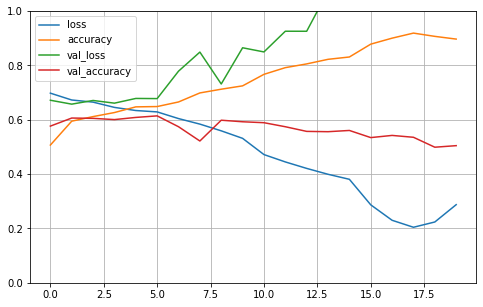


2023-03-21 15:43:03.271032

Testing # 1 5
2023-03-21 15:43:03.271133
2023-03-21 15:43:03.271173
PREDICT
2023-03-21 15:43:03.494175
Test 1:0 457:419 52.17%
Predict 1:0 227:649 25.91%
Test sizes (876, 4997) (876,)
Range of scores: 1.0771422e-09 to 1.0
Score threshold 0.5
Confusion matrix
 [[317 102]
 [332 125]]
Normalized matrix
 [[0.36187215 0.11643836]
 [0.37899543 0.14269406]]


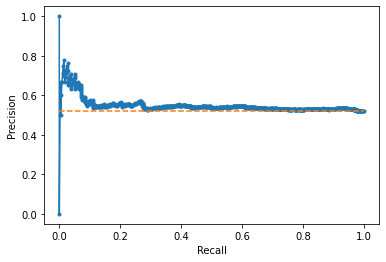

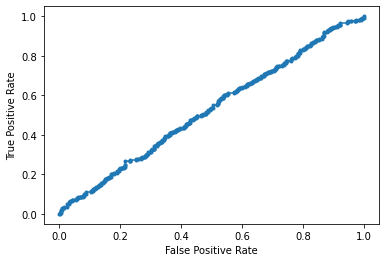

Accuracy: 50.46% Precision: 55.07% Recall: 27.35%
F1: 36.55% MCC: 0.0343
AUPRC: 54.88% AUROC: 52.85%
 accuracy [50.456621004566216]
 precision [55.06607929515418]
 recall [27.35229759299781]
 F1 [36.549707602339176]
 MCC [0.034300265896061215]
 AUPRC [54.87655822688069]
 AUROC [52.84542230903004]
2023-03-21 15:43:05.107497

Training # 2 1
2023-03-21 15:43:05.107689
2023-03-21 15:43:05.107738
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Computed class weights: {0: 1.0265330188679245, 1: 0.9748040313549832}
Valid 1:0 472:415 53.21%
FIT
2023-03-21 15:43:06.289899


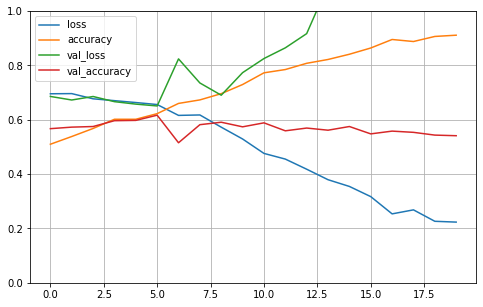


2023-03-21 15:45:14.794794

Testing # 2 1
2023-03-21 15:45:14.794908
2023-03-21 15:45:14.794965
PREDICT
2023-03-21 15:45:15.037115
Test 1:0 472:415 53.21%
Predict 1:0 405:482 45.66%
Test sizes (887, 4997) (887,)
Range of scores: 6.1523764e-09 to 1.0
Score threshold 0.5
Confusion matrix
 [[245 170]
 [237 235]]
Normalized matrix
 [[0.27621195 0.19165727]
 [0.26719278 0.26493799]]


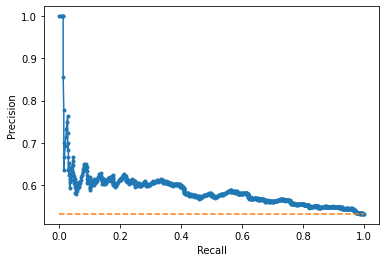

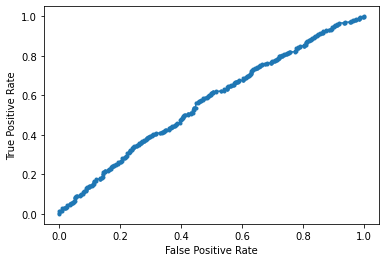

Accuracy: 54.11% Precision: 58.02% Recall: 49.79%
F1: 53.59% MCC: 0.0884
AUPRC: 58.86% AUROC: 56.46%
 accuracy [54.11499436302142]
 precision [58.0246913580247]
 recall [49.78813559322034]
 F1 [53.59179019384265]
 MCC [0.08839410552607821]
 AUPRC [58.85546341071238]
 AUROC [56.46033285685114]
2023-03-21 15:45:16.669480

Training # 2 2
2023-03-21 15:45:16.670604
2023-03-21 15:45:16.670660
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Computed class weights: {0: 1.0327433628318583, 1: 0.9692691029900332}
Valid 1:0 452:416 52.07%
FIT
2023-03-21 15:45:17.861523


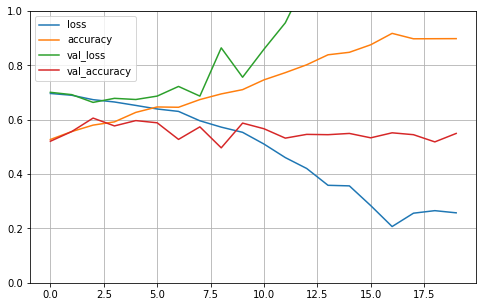


2023-03-21 15:47:41.805943

Testing # 2 2
2023-03-21 15:47:41.806065
2023-03-21 15:47:41.806106
PREDICT
2023-03-21 15:47:42.046840
Test 1:0 452:416 52.07%
Predict 1:0 595:273 68.55%
Test sizes (868, 4997) (868,)
Range of scores: 3.412246e-08 to 1.0
Score threshold 0.5
Confusion matrix
 [[149 267]
 [124 328]]
Normalized matrix
 [[0.17165899 0.30760369]
 [0.14285714 0.37788018]]


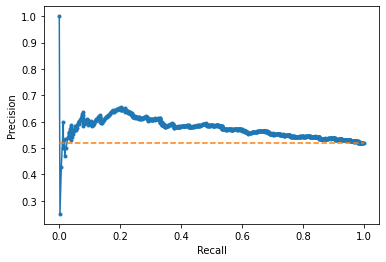

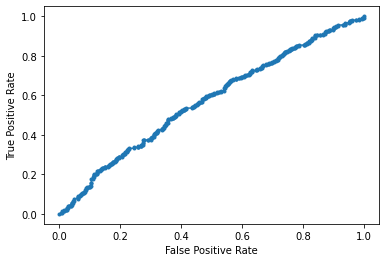

Accuracy: 54.95% Precision: 55.13% Recall: 72.57%
F1: 62.66% MCC: 0.0902
AUPRC: 57.34% AUROC: 57.12%
 accuracy [54.953917050691246]
 precision [55.12605042016807]
 recall [72.56637168141593]
 F1 [62.6552053486151]
 MCC [0.09020087222165742]
 AUPRC [57.340806411405374]
 AUROC [57.117139635806666]
2023-03-21 15:47:43.735037

Training # 2 3
2023-03-21 15:47:43.735217
2023-03-21 15:47:43.735264
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Computed class weights: {0: 1.0296361502347418, 1: 0.97202216066482}
Valid 1:0 453:407 52.67%
FIT
2023-03-21 15:47:44.987334


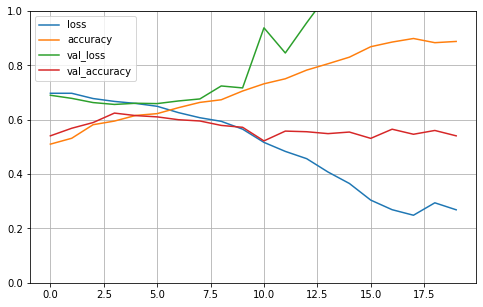


2023-03-21 15:50:08.421135

Testing # 2 3
2023-03-21 15:50:08.421242
2023-03-21 15:50:08.421281
PREDICT
2023-03-21 15:50:08.641355
Test 1:0 453:407 52.67%
Predict 1:0 506:354 58.84%
Test sizes (860, 4997) (860,)
Range of scores: 2.2709132e-09 to 1.0
Score threshold 0.5
Confusion matrix
 [[183 224]
 [171 282]]
Normalized matrix
 [[0.2127907  0.26046512]
 [0.19883721 0.32790698]]


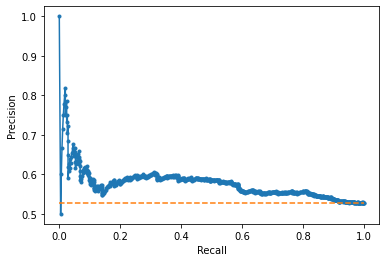

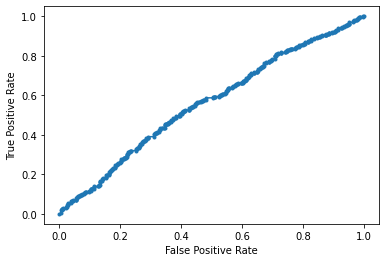

Accuracy: 54.07% Precision: 55.73% Recall: 62.25%
F1: 58.81% MCC: 0.0732
AUPRC: 57.64% AUROC: 56.14%
 accuracy [54.06976744186046]
 precision [55.73122529644269]
 recall [62.251655629139066]
 F1 [58.811261730969754]
 MCC [0.07319707865989625]
 AUPRC [57.639002048764375]
 AUROC [56.14386210412701]
2023-03-21 15:50:10.484520

Training # 2 4
2023-03-21 15:50:10.485256
2023-03-21 15:50:10.485314
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Computed class weights: {0: 1.0486778846153846, 1: 0.9556407447973713}
Valid 1:0 432:447 49.15%
FIT
2023-03-21 15:50:11.699228


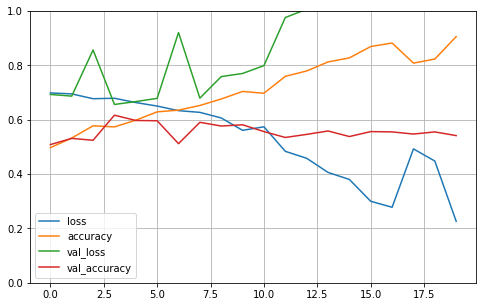


2023-03-21 15:52:35.669719

Testing # 2 4
2023-03-21 15:52:35.669814
2023-03-21 15:52:35.669858
PREDICT
2023-03-21 15:52:35.953327
Test 1:0 432:447 49.15%
Predict 1:0 611:268 69.51%
Test sizes (879, 4997) (879,)
Range of scores: 2.5348749e-07 to 0.99999964
Score threshold 0.5
Confusion matrix
 [[156 291]
 [112 320]]
Normalized matrix
 [[0.1774744  0.33105802]
 [0.12741752 0.36405006]]


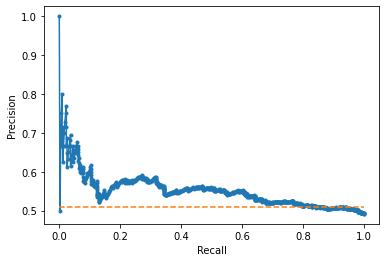

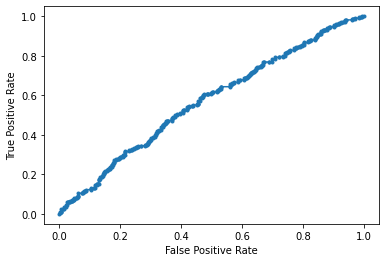

Accuracy: 54.15% Precision: 52.37% Recall: 74.07%
F1: 61.36% MCC: 0.0974
AUPRC: 55.08% AUROC: 57.07%
 accuracy [54.152445961319685]
 precision [52.373158756137485]
 recall [74.07407407407408]
 F1 [61.3614573346117]
 MCC [0.09744617623440006]
 AUPRC [55.08089607556331]
 AUROC [57.07106015411385]
2023-03-21 15:52:38.160423

Training # 2 5
2023-03-21 15:52:38.172945
2023-03-21 15:52:38.173331
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Computed class weights: {0: 1.0367952522255193, 1: 0.9657269209508016}
Valid 1:0 449:426 51.31%
FIT
2023-03-21 15:52:40.663084


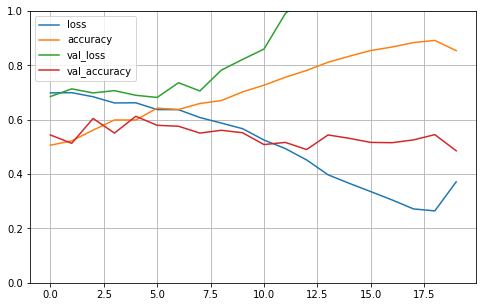


2023-03-21 15:55:04.135048

Testing # 2 5
2023-03-21 15:55:04.135147
2023-03-21 15:55:04.135189
PREDICT
2023-03-21 15:55:04.368310
Test 1:0 449:426 51.31%
Predict 1:0 301:574 34.40%
Test sizes (875, 4997) (875,)
Range of scores: 1.1640943e-07 to 0.9999999
Score threshold 0.5
Confusion matrix
 [[275 151]
 [299 150]]
Normalized matrix
 [[0.31428571 0.17257143]
 [0.34171429 0.17142857]]


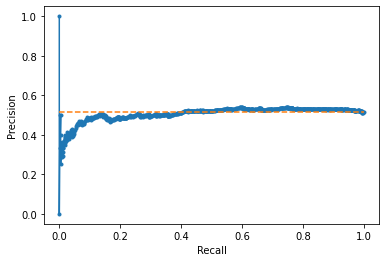

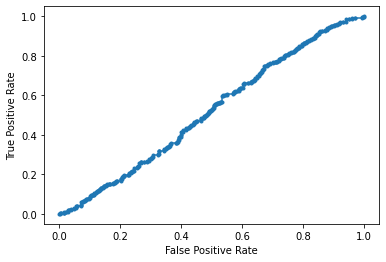

Accuracy: 48.57% Precision: 49.83% Recall: 33.41%
F1: 40.00% MCC: -0.0214
AUPRC: 50.71% AUROC: 51.84%
 accuracy [48.57142857142857]
 precision [49.83388704318937]
 recall [33.4075723830735]
 F1 [40.0]
 MCC [-0.02144796395647417]
 AUPRC [50.71068107173276]
 AUROC [51.83558664533601]
2023-03-21 15:55:05.533275


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_sequence(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 53.11% std 2.33
 precision mean 54.81% std 2.24
 recall mean 52.91% std 17.20
 F1 mean 52.50% std 9.61
 MCC mean 0.07% std 0.04
 AUPRC mean 55.93% std 2.49
 AUROC mean 55.40% std 2.32
 accuracy [[52.41379310344828], [55.995475113122176], [51.47232037691401], [54.9438202247191], [50.456621004566216], [54.11499436302142], [54.953917050691246], [54.06976744186046], [54.152445961319685], [48.57142857142857]]
 precision [[56.470588235294116], [55.20628683693517], [55.067567567567565], [55.17857142857143], [55.06607929515418], [58.0246913580247], [55.12605042016807], [55.73122529644269], [52.373158756137485], [49.83388704318937]]
 recall [[41.92139737991266], [63.57466063348416], [36.87782805429865], [67.3202614379085], [27.35229759299781], [49.78813559322034], [72.56637168141593], [62.251655629139066], [74.07407407407408], [33.4075723830735]]
 F1 [[48.1203007518797], [59.095688748685596], [44.173441734417345], [60.64769381746812], [36.549707602339176], [53.59179019384265], [6